# HW1
### Такташева Катя

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import spacy
import warnings

from nltk.corpus import stopwords
from scipy.stats import pearsonr, spearmanr 
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import ElasticNet, LinearRegression, LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from tqdm.auto import tqdm

from warnings import filterwarnings
filterwarnings('ignore')

In [208]:
data = pd.read_csv('Shoes_Data.csv')

In [209]:
data

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,₹279.00,2.9 out of 5 stars,2389 ratings,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men
1,Bourge Men's Loire-z126 Running Shoes,₹479.00,3.9 out of 5 stars,11520 ratings,The product will be an excellent pick for you....,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men
2,T-Rock Men's Sneaker,₹430.00,3.3 out of 5 stars,1251 ratings,Flaunt with these stylish and unique red casua...,Worth to its amount|| Go for it|| Perfect|| 5 ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men
3,Robbie jones Sneakers Casual Canvas Fabric Col...,₹499.00,4.2 out of 5 stars,3 ratings,Robbie Jones Shoes Are Designed To Keeping In ...,Sup quality|| Good but not expected|| Awesome 👌.!,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Men
4,Sparx Men's Sd0323g Sneakers,₹499.00,4.2 out of 5 stars,20110 ratings,Sparx is a spectacular range of footwear from ...,Best|| Satisfied!|| Affordable beauty 😘😘😘😘 the...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men
...,...,...,...,...,...,...,...,...
1225,Nike Men's React Vision Running Shoes,₹7256.00,4.4 out of 5 stars,200 ratings,The Nike react vision is a STORY of surreal co...,Must buy|| not have a great fiting but great q...,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Women
1226,Puma Men's B.O.G Limitless Hi Evoknit Sneakers,₹5822.00,4.3 out of 5 stars,25 ratings,The B.O.G limitless is Puma's key style for th...,Worth buying !|| Classy Bold and Stylish !!|| ...,4.0 out of 5 stars|| 5.0 out of 5 stars|| 3.0 ...,Women
1227,new balance Women's FuelCell Echolucent Runnin...,₹5362.00,4.5 out of 5 stars,817 ratings,Lead the pack in New Balance’s Echolucent snea...,size variation in product recd n size chart|| ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Women
1228,Nike Women's WMNS Air Zoom Pegasus 37 Running ...,₹7480.00,4.5 out of 5 stars,67 ratings,Nike మహిళల రన్నింగ్ షూ ఫీల్స్ మరియు రూపం మృదువ...,Verified Purchase|| Verified Purchase|| Verifi...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 4.0 ...,Women


# Задание 1: Предсказание цены по описанию товара

### 0. Определение задачи
Для начала определимся классификация это или регрессия: **регрессия**, т.к. ответ принадлежит множеству вещественных чисел.

### 1. Исследуем данные

**1.1** Посмотрим на данные в общем:

In [210]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                1230 non-null   object
 1   price                1230 non-null   object
 2   rating               1230 non-null   object
 3   total_reviews        1230 non-null   object
 4   product_description  1230 non-null   object
 5   reviews              1230 non-null   object
 6   reviews_rating       1230 non-null   object
 7   Shoe Type            1230 non-null   object
dtypes: object(8)
memory usage: 77.0+ KB


Видим, что у нас пустых значений, все фичи не числовые

**1.2** Проверим на наличие дублей и уберем

In [211]:
data.drop_duplicates(inplace=True, keep='first')
data.shape

(1015, 8)

**1.3** Приведем целевую переменную в числовое значение (уберем значок валюты) и посмотрим на ее распределение

In [212]:
data.price = data.price.apply(lambda x: float(x[1:]))

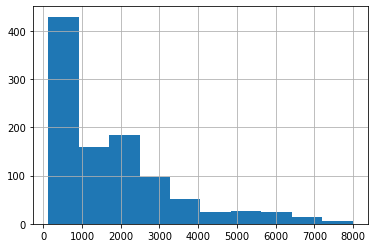

In [213]:
data.price.hist();

Видим, что распределение довольно "одностороннее" - большинство объектов находится в ценовом диапазоне [0-3000]

**1.4** Здесь конечно можно поисследовать зависимость целевой переменной от других признаков, например, `типа обуви` (может женская дороже мужской), `количества отзывов` (может чем  больше отзывов на товар, тем он лучше? хуже?) и т.д. но поскольку **мы делаем предсказание по описанию товара**, это кажется бессмысленным на данном этапе. 

Поэтому **посмотрим на какие-то более странные и абстрактные зависимости**: например, может быть `длина описания` влияет на цену? (может чем длиннее описание, тем оно более продуманно и соотвенственно товар более качественный? или наоборот, тут вспомним описания на китайских сайтах :) )

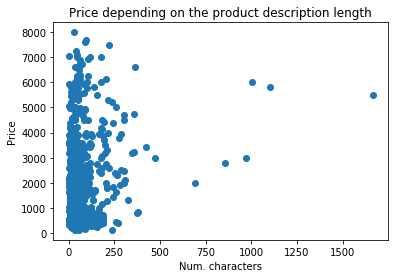

In [214]:
plt.scatter(data.product_description.apply(lambda x: len(x.split())), data.price)
plt.title('Price depending on the product description length')
plt.ylabel('Price')
plt.xlabel('Num. characters');

In [215]:
print('Pearson correlation:', pearsonr(data.product_description.apply(lambda x: len(x.split())),
                                       data.price)[0])
print('Spearman correlation:', spearmanr(data.product_description.apply(lambda x: len(x.split())),
                                         data.price).correlation)

Pearson correlation: 0.16912848482755533
Spearman correlation: 0.049392140005639004


Аналогично посмотрим на название:

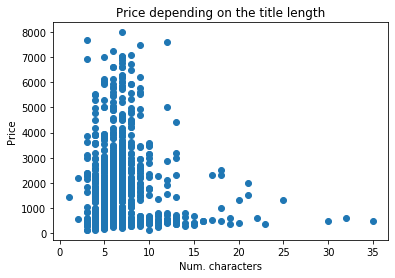

In [216]:
plt.scatter(data.title.apply(lambda x: len(x.split())), data.price)
plt.title('Price depending on the title length')
plt.ylabel('Price')
plt.xlabel('Num. characters');

In [217]:
print('Pearson correlation:', pearsonr(data.title.apply(lambda x: len(x.split())),
                                       data.price)[0])
print('Spearman correlation:', spearmanr(data.title.apply(lambda x: len(x.split())),
                                         data.price).correlation)

Pearson correlation: -0.026798230858848783
Spearman correlation: 0.10345725889648019


Как видим, никаких корреляций не наблюдается, что ожидаемо, так что пойдем дальше

**1.5** Удалим ненужные нам столбцы данных

In [218]:
data.drop(columns=['rating', 'total_reviews', 'reviews_rating', 'reviews', 'Shoe Type'], inplace=True)

**1.6** Теперь объединим все текстовые признаки в одну длинную строку, чтобы нам было удобно с ними работать:

In [219]:
data['text'] = data['title'] + ' ' + data['product_description'] 

In [220]:
data

,title,price,product_description,text
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,279.0,Elevate your style with this classy pair of Ru...,CLYMB Outdoor Sports Running Shoes for Mens Bo...
1,Bourge Men's Loire-z126 Running Shoes,479.0,The product will be an excellent pick for you....,Bourge Men's Loire-z126 Running Shoes The prod...
2,T-Rock Men's Sneaker,430.0,Flaunt with these stylish and unique red casua...,T-Rock Men's Sneaker Flaunt with these stylish...
3,Robbie jones Sneakers Casual Canvas Fabric Col...,499.0,Robbie Jones Shoes Are Designed To Keeping In ...,Robbie jones Sneakers Casual Canvas Fabric Col...
4,Sparx Men's Sd0323g Sneakers,499.0,Sparx is a spectacular range of footwear from ...,Sparx Men's Sd0323g Sneakers Sparx is a specta...
...,...,...,...,...
1193,Nike Men's React Vision Running Shoes,7256.0,The Nike react vision is a STORY of surreal co...,Nike Men's React Vision Running Shoes The Nike...
1194,Puma Men's B.O.G Limitless Hi Evoknit Sneakers,5822.0,The B.O.G limitless is Puma's key style for th...,Puma Men's B.O.G Limitless Hi Evoknit Sneakers...
1195,new balance Women's FuelCell Echolucent Runnin...,5362.0,Lead the pack in New Balance’s Echolucent snea...,new balance Women's FuelCell Echolucent Runnin...
1196,Nike Women's WMNS Air Zoom Pegasus 37 Running ...,7480.0,Nike మహిళల రన్నింగ్ షూ ఫీల్స్ మరియు రూపం మృదువ...,Nike Women's WMNS Air Zoom Pegasus 37 Running ...


### 2. Препроцессинг данных

In [221]:
#!python -m spacy download en_core_web_sm

In [222]:
nlp = spacy.load('en_core_web_sm')
# оставим отрицания, т.к. они будут полезны для оценки ревью
STOPWORDS = set([word for word in stopwords.words('english') if ("n't" not in word and
                                                                 word not in ['no', 'not'])])

In [223]:
#!pip install --quiet alphabet-detector

In [224]:
from alphabet_detector import AlphabetDetector
ad = AlphabetDetector()

**Что делаем:**
- токенизируем
- лемматизируем (очевидно, нам не нужно учитывать все возможные формы оного слова, потому что наши модели все равно не учитывают контекст)
- приведем к нижнему регистру (по той же причине в принципе, в целом можно оставить и cased версию, но мне не кажется, что это улучшит/ухудшит результаты)
- уберем стопслова
- уберем неподходящие символы: числа, пунктуацию (т.к. наши модели опираются на частотности, то их извлечение не испортит ничего, а наоборот избавит от большого количества лищних данных)
- уберем не латинские символы (они странные и ненужные)

In [225]:
def lemmatize(text: str) -> str:
    """
    Tokenize and lemmatize text data,
    delete stopwords and non-alphabetical characters
    :param text: text to lemmatize
    :param model: tokenizer + lemmatizer model
    :return: lemmatized text
    """
    text = text.lower()
    text = [word.lemma_ for word in nlp(text) if (ad.is_latin(word.lemma_) and
                                                  word.lemma_.isalpha() and
                                                  word.lemma_ not in STOPWORDS)]
    return ' '.join(text)


In [226]:
tqdm.pandas()
data['lemmatized'] = data['text'].progress_apply(lemmatize)

In [227]:
data['text'][1]

"Bourge Men's Loire-z126 Running Shoes The product will be an excellent pick for you. It ensures an easy maintenance."

In [228]:
data['lemmatized'][1]

'bourge man loire running shoe product excellent pick ensure easy maintenance'

### 3. Векторизация
#### 3.1 BoW

In [229]:
cv = CountVectorizer()
bow_features = cv.fit_transform(data['lemmatized']).toarray()

#### 3.2 TF-IDF

In [230]:
tfidf = TfidfVectorizer()
tfidf_features = tfidf.fit_transform(data['lemmatized']).toarray()

### 4.  Подбор параметров
#### 4.1 BoW

In [231]:
X_train, X_test, y_train, y_test = train_test_split(bow_features, data['price'].values,
                                                    test_size=0.2, random_state=42)

#### 4.1.1 LinearRegression
Тут особо нет параметров, так что просто сделаем предсказание, как своеобразную точку отсчета

In [232]:
def scores(true: np.array, pred: np.array):
    print('MSE:', mean_squared_error(true, pred))
    print('MAE:', mean_absolute_error(true, pred))
    print('RMSE:', mean_squared_error(true, pred, squared=False))

In [233]:
lr = LinearRegression()
lr.fit(X_train, y_train)
scores(y_test, lr.predict(X_test))

MSE: 1.3505968391346267e+30
MAE: 656259561924050.4
RMSE: 1162151814151071.5


как видим, простая модель совсем не справляется с данными

#### 4.1.2 ElasticNet

In [491]:
en = ElasticNet()
gs = GridSearchCV(en,
                  param_grid = {
                     'alpha': np.arange(0, 1.2, 0.2),
                     'l1_ratio': np.arange(0, 1.2, 0.2),
                 },
                 scoring=make_scorer(mean_squared_error, greater_is_better=False))
elastic = gs.fit(X_train, y_train)

In [492]:
scores(y_test, elastic.predict(X_test))

MSE: 1429609.1846327628
MAE: 771.6599845459184
RMSE: 1195.6626550297383


Здесь результаты получше, давайте посмотрим на среднее значение таргета, чтобы понять приемлемость такой ошибки:

In [234]:
y_test.mean()

1752.621921182266

Будем смотреть на MAE (т.к. это по сути наши "чистые значение", без степени и тд, а значит лучше представляют наши потери).

Видим, что MAE получилась на 66% меньше среднего значения таргета, что хорошо (потому что не больше, ура), но все еще довольно много. Тем не менее, если посмотреть на данные, то они 1) маленького размера (всего около 1000 примеров), что усложняет обучение; 2) довольно нелинейные, что значит, что идеального решения простой линейной моделью вряд ли получится добиться

Посмотрим на данные:

In [51]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(bow_features)

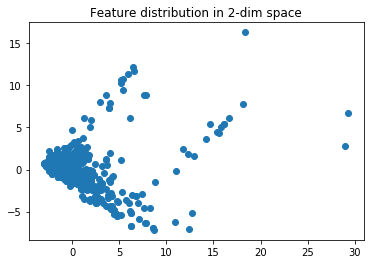

In [55]:
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.title('Feature distribution in 2-dim space');

####  4.1.3  RandomForest

In [56]:
rf = RandomForestRegressor()
gs = GridSearchCV(rf,
                  param_grid = {
                      'n_estimators': range(50, 210, 50),
                      'max_depth': range(100, 1100, 300),                      
                  },
                 scoring=make_scorer(mean_squared_error, greater_is_better=False))
forest = gs.fit(X_train, y_train)

In [57]:
scores(y_test, forest.predict(X_test))

MSE: 1417043.902772216
MAE: 669.5862406831629
RMSE: 1190.3965317373097


Случайный лес, ожидаемо, справляется лучше, чем все предыдущие модели, поскольку нелинеен, но тем не менее, данных слишком мало и такое кодировние признаков, как BoW, не помогает, т.к. у нас много пустых значений и вектора несут довольно мало информации, поэтому качество все еще довольно плохое



#### 4.2 TFIDF

Проделаем все то же самое

In [59]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, data['price'].values,
                                                    test_size=0.2, random_state=42)

Посмотрим на распределение:

In [66]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(tfidf_features)

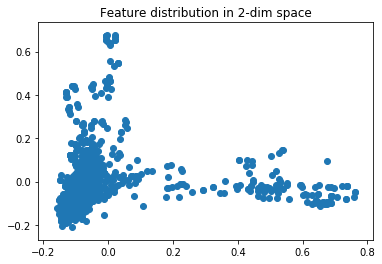

In [68]:
plt.scatter(X_pca[:,0], X_pca[:,1])
plt.title('Feature distribution in 2-dim space');

**4.2.1 Linear Regression**

In [60]:
lr = LinearRegression()
lr.fit(X_train, y_train)
scores(y_test, lr.predict(X_test))

MSE: 2.366974052200052e+28
MAE: 100345625808954.48
RMSE: 153849733577931.56


**4.2.2 ElasticNet** 

In [62]:
en = ElasticNet()
gs = GridSearchCV(en,
                  param_grid = {
                     'alpha': np.arange(0, 1.2, 0.2),
                     'l1_ratio': np.arange(0, 1.2, 0.2)
                 })
elastic = gs.fit(X_train, y_train)

In [63]:
scores(y_test, elastic.predict(X_test))

MSE: 1477937.4520932012
MAE: 758.3802027719054
RMSE: 1215.7045085435857


####  4.1.3  RandomForest

In [64]:
rf = RandomForestRegressor()
gs = GridSearchCV(rf,
                  param_grid = {
                      'n_estimators': range(50, 210, 50),
                      'max_depth': range(100, 1100, 300),                      
                  })
forest = gs.fit(X_train, y_train)

In [65]:
scores(y_test, forest.predict(X_test))

MSE: 1646304.4305191298
MAE: 726.2425081151653
RMSE: 1283.0839530284563


Как видим, все тренды сохраняются: лучше всего себя показал Random Forest, хуже всего с задачей справляется простая линейная регрессия, что логично.

Если сравнивать признаки из BoW и TF-IDF, то лучшие результаты достигаются на признаках, извлеченных при помощи TF-IDF, что тоже ожидаемо, поскольку TF-IDF хранит больше информации о словах, выделяя более и менее важные их них.

# Задание 2: Предсказание оценки товара пользователем по его отзыву

### 0. Определение задачи
Для начала определимся классификация это или регрессия: **классификация**, т.к. ответ принадлежит конечному множеству чисел (хотя можно и регрессию)
### 1. Исследуем данные

**1.1** Посмотрим на данные в общем:

In [142]:
data = pd.read_csv('Shoes_Data.csv')

In [143]:
data

,title,price,rating,total_reviews,product_description,reviews,reviews_rating,Shoe Type
0,CLYMB Outdoor Sports Running Shoes for Mens Boy,₹279.00,2.9 out of 5 stars,2389 ratings,Elevate your style with this classy pair of Ru...,Not happy with product|| It's not as expected....,1.0 out of 5 stars|| 1.0 out of 5 stars|| 3.0 ...,Men
1,Bourge Men's Loire-z126 Running Shoes,₹479.00,3.9 out of 5 stars,11520 ratings,The product will be an excellent pick for you....,Memory cushioning in these shoes is the best f...,5.0 out of 5 stars|| 1.0 out of 5 stars|| 5.0 ...,Men
2,T-Rock Men's Sneaker,₹430.00,3.3 out of 5 stars,1251 ratings,Flaunt with these stylish and unique red casua...,Worth to its amount|| Go for it|| Perfect|| 5 ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men
3,Robbie jones Sneakers Casual Canvas Fabric Col...,₹499.00,4.2 out of 5 stars,3 ratings,Robbie Jones Shoes Are Designed To Keeping In ...,Sup quality|| Good but not expected|| Awesome 👌.!,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Men
4,Sparx Men's Sd0323g Sneakers,₹499.00,4.2 out of 5 stars,20110 ratings,Sparx is a spectacular range of footwear from ...,Best|| Satisfied!|| Affordable beauty 😘😘😘😘 the...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Men
...,...,...,...,...,...,...,...,...
1225,Nike Men's React Vision Running Shoes,₹7256.00,4.4 out of 5 stars,200 ratings,The Nike react vision is a STORY of surreal co...,Must buy|| not have a great fiting but great q...,5.0 out of 5 stars|| 3.0 out of 5 stars|| 5.0 ...,Women
1226,Puma Men's B.O.G Limitless Hi Evoknit Sneakers,₹5822.00,4.3 out of 5 stars,25 ratings,The B.O.G limitless is Puma's key style for th...,Worth buying !|| Classy Bold and Stylish !!|| ...,4.0 out of 5 stars|| 5.0 out of 5 stars|| 3.0 ...,Women
1227,new balance Women's FuelCell Echolucent Runnin...,₹5362.00,4.5 out of 5 stars,817 ratings,Lead the pack in New Balance’s Echolucent snea...,size variation in product recd n size chart|| ...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 5.0 ...,Women
1228,Nike Women's WMNS Air Zoom Pegasus 37 Running ...,₹7480.00,4.5 out of 5 stars,67 ratings,Nike మహిళల రన్నింగ్ షూ ఫీల్స్ మరియు రూపం మృదువ...,Verified Purchase|| Verified Purchase|| Verifi...,5.0 out of 5 stars|| 5.0 out of 5 stars|| 4.0 ...,Women


In [144]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   title                1230 non-null   object
 1   price                1230 non-null   object
 2   rating               1230 non-null   object
 3   total_reviews        1230 non-null   object
 4   product_description  1230 non-null   object
 5   reviews              1230 non-null   object
 6   reviews_rating       1230 non-null   object
 7   Shoe Type            1230 non-null   object
dtypes: object(8)
memory usage: 77.0+ KB


Видим, что у нас пустых значений, все фичи не числовые

**1.2** Проверим на наличие дублей и уберем

In [145]:
data.drop_duplicates(inplace=True, keep='first')
data.shape

(1015, 8)

**1.3** Приведем целевую переменную в числовое значение и посмотрим на ее распределение

In [146]:
data.rating = data.rating.apply(lambda x: float(x.split()[0]))

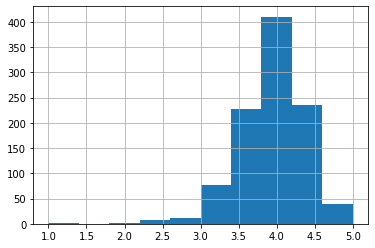

In [147]:
data.rating.hist();

Видим, что у нас тут практически нормальное распределение с большинством объектов с рейтингом 4. Что не очень, потому что у нас будет сильный дисбаланс классов :(

Anyway, сейчас у нас все еще continious данные, а для классификации нам нужны категориальные данные, поэтому преобразуем их. Здесь есть два варианта: либо преобразовать оценки в стандартную пятибалльную шкалу (1-2-3-4-5), либо закодировать данные при помощи какого-нибудь LabelEncoder'а (1.0 = 0, 1.1 = 1, 1.2 = 2 и тд.)

В случае со вторым вариантом получим ОЧЕНЬ много лейблов (около 40), а данных у нас не так много, поэтому предпочту первый вариант

In [148]:
data.rating = data.rating.apply(round)

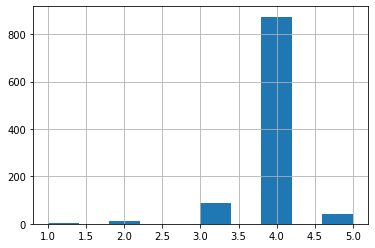

In [149]:
data.rating.hist();

In [150]:
data.rating.value_counts()

4    874
3     89
5     40
2     10
1      2
Name: rating, dtype: int64

Конечно, видим ужасный дисбаланс, по-хорошему надо бы его исправить downsampling'ом, но у нас и так мало данных :(

**1.4** Здесь опять же можно поисследовать другие факторы, однако хочется все же использовать только тексты, поэтому как и выше посмотрим только на тексты отзывов

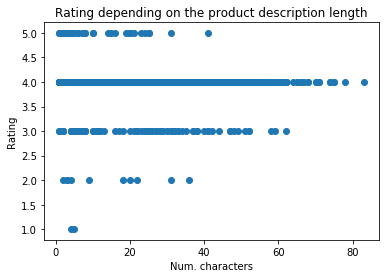

In [151]:
plt.scatter(data.reviews.apply(lambda x: len(x.split())), data.rating)
plt.title('Rating depending on the product description length')
plt.ylabel('Rating')
plt.xlabel('Num. characters');

In [152]:
print('Pearson correlation:', pearsonr(data.reviews.apply(lambda x: len(x.split())),
                                       data.rating)[0])
print('Spearman correlation:', spearmanr(data.reviews.apply(lambda x: len(x.split())),
                                         data.rating).correlation)

Pearson correlation: 0.03877466564775599
Spearman correlation: 0.013241291984633604


Как видим, зависимости нет

**1.5** Уберем ненужные столбцы

In [153]:
data.drop(columns=['title', 'price', 'total_reviews',
                   'reviews_rating', 'product_description', 'Shoe Type'], inplace=True)

In [154]:
data

,rating,reviews
0,3,Not happy with product|| It's not as expected....
1,4,Memory cushioning in these shoes is the best f...
2,3,Worth to its amount|| Go for it|| Perfect|| 5 ...
3,4,Sup quality|| Good but not expected|| Awesome 👌.!
4,4,Best|| Satisfied!|| Affordable beauty 😘😘😘😘 the...
...,...,...
1193,4,Must buy|| not have a great fiting but great q...
1194,4,Worth buying !|| Classy Bold and Stylish !!|| ...
1195,4,size variation in product recd n size chart|| ...
1196,4,Verified Purchase|| Verified Purchase|| Verifi...


### 2. Препроцессинг данных

Тут делаем то же самое, что и для регрессии:

- токенизируем
- лемматизируем (очевидно, нам не нужно учитывать все возможные формы оного слова, потому что наши модели все равно не учитывают контекст)
- приведем к нижнему регистру (по той же причине в принципе, в целом можно оставить и cased версию, но мне не кажется, что это улучшит/ухудшит результаты)
- уберем неподходящие символы: числа, пунктуацию (т.к. наши модели опираются на частотности, то их извлечение не испортит ничего, а наоборот избавит от большого количества лищних данных)
- уберем не латинские символы (они странные и ненужные)

**НО:** 
+ сначала поделим тексты по ||

In [155]:
data['lemmatized'] = data.reviews.apply(lambda x: ' '.join(x.split('||')))

In [156]:
data['lemmatized'] = data.lemmatized.progress_apply(lemmatize)

In [157]:
data['reviews'][4]

'Best|| Satisfied!|| Affordable beauty 😘😘😘😘 the eye catcher 😊|| Economical and soft for feet|| Good looking shoe however buy one size low|| Must bye for puja|| Why so much variation in sizes.|| Review after 30 days of use|| You get what you pay for|| Cheap and branded spent 588/- x 5 to 6 time is better than 4500/- one time'

In [158]:
data['lemmatized'][4]

'good satisfied affordable beauty eye catcher economical soft foot good looking shoe however buy one size low must bye puja much variation size review day use get pay cheap brand spend x time well one time'

### 3. Векторизация
#### 3.1 BoW

In [159]:
cv = CountVectorizer()
bow_features = cv.fit_transform(data['lemmatized']).toarray()

#### 3.2 TF-IDF

In [160]:
tfidf = TfidfVectorizer()
tfidf_features = tfidf.fit_transform(data['lemmatized']).toarray()

### 4.  Подбор параметров
#### 4.1 BoW

In [181]:
X_train, X_test, y_train, y_test = train_test_split(bow_features, data['rating'].values,
                                                    test_size=0.2, random_state=42)

In [182]:
print('Train set labels:', pd.DataFrame(y_train).value_counts(), sep='\n')

Train set labels:
4    695
3     73
5     33
2      9
1      2
dtype: int64


In [183]:
print('Test set labels:', pd.DataFrame(y_test).value_counts(), sep='\n')

Test set labels:
4    179
3     16
5      7
2      1
dtype: int64


Как видим, распределение не самое лучшее, но ничего не поделать, т.к. данных мало и они не сбалансированны, так что будем работать с тем что есть

Посмотрим на распределение данных, воспользовавшись PCA (который старается сохранить изначальную структуру при преобразовании):

In [184]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(bow_features)

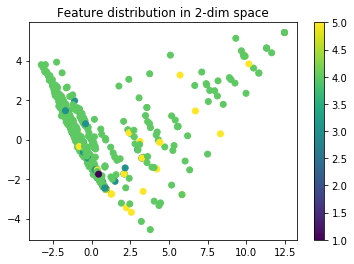

In [185]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=data['rating'].values)
plt.colorbar()
plt.title("Feature distribution in 2-dim space");

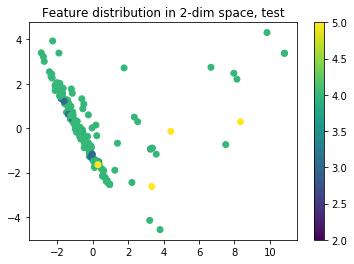

In [186]:
plt.scatter(pca.transform(X_test)[:,0], pca.transform(X_test)[:,1], c=y_test)
plt.colorbar()
plt.title("Feature distribution in 2-dim space, test");

#### 4.1.1 LinearClassification

In [187]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(classification_report(lr.predict(X_test), y_test))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         0
           3       0.06      0.25      0.10         4
           4       0.98      0.88      0.93       199
           5       0.00      0.00      0.00         0

    accuracy                           0.87       203
   macro avg       0.26      0.28      0.26       203
weighted avg       0.97      0.87      0.91       203



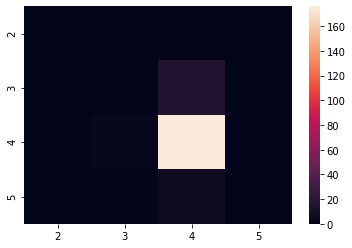

In [188]:
sns.heatmap(confusion_matrix(y_test, lr.predict(X_test)),
            xticklabels=lr.classes_[1:], yticklabels=lr.classes_[1:])

Ожидаемо, видим, что лучше всего определяется 4 класс, который самый представительный в нашей выборке, качество на нем 0.93 (f-score), второй по определимости -- класс 3, он же второй по количеству примеров, но качестсво уже всего 0.10

В целом видим, что качество модели 0.91 (взвещенный f-score), однако понимаем, что такое достигается из-за большого преобладания 4 класса и отсутствия достаточного количества примеров из других классов

#### 4.1.2 KNN

In [189]:
knn = KNeighborsClassifier()
gs = GridSearchCV(knn,
                  param_grid = {
                      'n_neighbors': range(2, 10, 50),           
                  })
knn = gs.fit(X_train, y_train)

In [190]:
print(classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         1
           3       0.12      0.25      0.17        16
           4       0.90      0.79      0.84       179
           5       0.50      0.14      0.22         7

    accuracy                           0.72       203
   macro avg       0.31      0.24      0.25       203
weighted avg       0.82      0.72      0.76       203



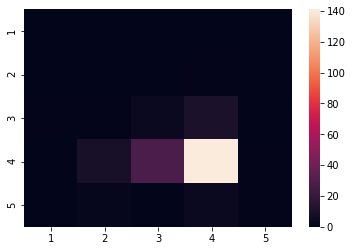

In [191]:
sns.heatmap(confusion_matrix(y_test, knn.predict(X_test)),
            xticklabels=lr.classes_, yticklabels=lr.classes_);

KNN с задачей справляется хуже, что видимо связано с распределением данных (см. картинку выше). Т.к. данные находятся "в куче", т.е. распределены примерно в одном месте, то алгоритм ближайшего соседа будет работать плохо, т.к. соседи не обязательно будут объектами из верного класса (см. объекты класса 5 (желтые точки) на картинке выше).

Качество модели всего 0.76 (взвешенный f-score). Аналогично простой линейной классификации, лучше всего определяется 4 класс, НО в KNN попадают и объекты 5 класса (что хорошо, что мы их не игнорируем)

#### 4.1.3 Random Forest

In [192]:
rf = RandomForestClassifier()
gs = GridSearchCV(rf,
                  param_grid = {
                      'n_estimators': range(50, 210, 50),
                      'max_depth': range(100, 1100, 300),                      
                  })
forest = gs.fit(X_train, y_train)

In [193]:
print(classification_report(y_test, forest.predict(X_test)))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00        16
           4       0.89      0.98      0.93       179
           5       1.00      0.14      0.25         7

    accuracy                           0.87       203
   macro avg       0.47      0.28      0.30       203
weighted avg       0.82      0.87      0.83       203



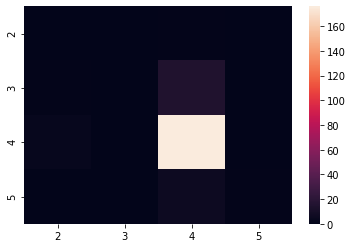

In [194]:
sns.heatmap(confusion_matrix(y_test, forest.predict(X_test)),
            xticklabels=lr.classes_[1:], yticklabels=lr.classes_[1:]);

Random Forest ведет себя похоже на модель линейной классификации, однако выделяет 4 и 5 классы, что можно так же попробовать объяснить распределением данных, в которых 5 класс кажется более отделимым от 4 чем 3. Хотя это довольно странно и видимо так сложилось, что 5 класс более distinctive для алгоритма. Но вообще я склоняюсь к тому, что это скорее влияние рандома, потому что оба 3 и 5 класс представлены довольно небольшим количеством примеров

#### 4.2 TF-IDF

In [195]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, data['rating'].values,
                                                    test_size=0.2, random_state=42)

In [196]:
print('Train set labels:', pd.DataFrame(y_train).value_counts(), sep='\n')

Train set labels:
4    695
3     73
5     33
2      9
1      2
dtype: int64


In [197]:
print('Test set labels:', pd.DataFrame(y_test).value_counts(), sep='\n')

Test set labels:
4    179
3     16
5      7
2      1
dtype: int64


In [198]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(tfidf_features)

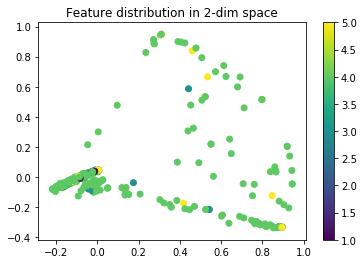

In [199]:
plt.scatter(X_pca[:,0], X_pca[:,1], c=data['rating'].values)
plt.colorbar()
plt.title("Feature distribution in 2-dim space");

#### 4.1.1 LinearClassification

In [200]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
print(classification_report(lr.predict(X_test), y_test))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         0
           3       0.00      0.00      0.00         0
           4       1.00      0.88      0.94       203
           5       0.00      0.00      0.00         0

    accuracy                           0.88       203
   macro avg       0.25      0.22      0.23       203
weighted avg       1.00      0.88      0.94       203



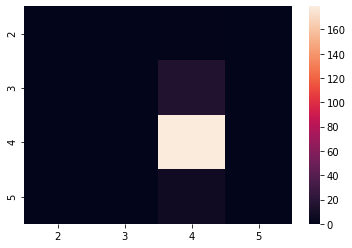

In [201]:
sns.heatmap(confusion_matrix(y_test, lr.predict(X_test)),
            xticklabels=lr.classes_[1:], yticklabels=lr.classes_[1:]);

#### 4.1.2 KNN

In [202]:
knn = KNeighborsClassifier()
gs = GridSearchCV(knn,
                  param_grid = {
                      'n_neighbors': range(2, 10, 50),           
                  })
knn = gs.fit(X_train, y_train)

In [203]:
print(classification_report(y_test, knn.predict(X_test)))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         1
           3       0.12      0.31      0.18        16
           4       0.90      0.74      0.81       179
           5       0.00      0.00      0.00         7

    accuracy                           0.67       203
   macro avg       0.21      0.21      0.20       203
weighted avg       0.81      0.67      0.73       203



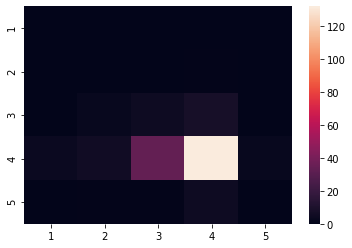

In [204]:
sns.heatmap(confusion_matrix(y_test, knn.predict(X_test)),
            xticklabels=lr.classes_, yticklabels=lr.classes_);

#### 4.1.3 Random Forest

In [205]:
rf = RandomForestClassifier()
gs = GridSearchCV(rf,
                  param_grid = {
                      'n_estimators': range(50, 210, 50),
                      'max_depth': range(100, 1100, 300),                      
                  })
forest = gs.fit(X_train, y_train)

In [206]:
print(classification_report(y_test, forest.predict(X_test)))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00        16
           4       0.88      0.98      0.93       179
           5       0.00      0.00      0.00         7

    accuracy                           0.87       203
   macro avg       0.22      0.25      0.23       203
weighted avg       0.78      0.87      0.82       203



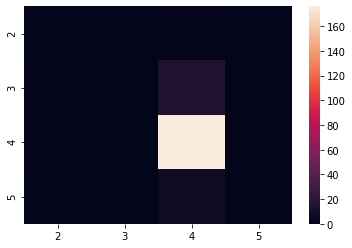

In [207]:
sns.heatmap(confusion_matrix(y_test, forest.predict(X_test)),
            xticklabels=lr.classes_[1:], yticklabels=lr.classes_[1:]);

TF-IDF признаки дают похожие результаты, однако все модели хуже справляются с определением малочисленных классов: так линейная классификация и Random Forest работают только на один класс, a KNN видит только два класс (as oposed to 3, как с BoW). Это довольно интересно, учитывая, что TF-IDF должен давать лучшие признаки, чем BoW..

Однако в целом очень сложно делать какие-то выводы по таким данным, потому что их действительно очень мало, особенно для классификации. Еще хуже то, что они очень несбалансированны, поэтому и результаты очень biased. 